# Amazon Product Review: Sentiment Analysis and Star Rating Prediction

#### Install required libraries

In [ ]:
!pip install swifter
!pip install pyLDAvis
!pip install unidecode
!pip install TextBlob
!pip install text2emotion

     |████████████████████████████████| 634kB 7.5MB/s 
     |████████████████████████████████| 471kB 14.7MB/s 
     |████████████████████████████████| 542kB 20.1MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
     |████████████████████████████████| 23.1MB 2.0MB/s 
     |████████████████████████████████| 17.2MB 125kB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 204kB 53.0MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 1.3MB 50.5MB/s 
     |████████████████████████████████| 2.9MB 53.3MB/s 
     |████████████████████████████████| 133kB 56.0MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 143kB 55.8MB/s 
     |████████████████████████████████| 296kB 54.1MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-cp36-

#### Import required libraries

In [ ]:
import time
import swifter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

from textblob import TextBlob
import text2emotion as te

import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import nltk
from nltk import FreqDist
nltk.downloader.download('vader_lexicon')
from nltk.sentiment import SentimentAnalyzer

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import re
import gzip
import string
import unidecode
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from wordcloud import WordCloud,STOPWORDS 

import sys
import heapq

sns.set()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
"""
We will ignore FutureWarning and DeprecationWarning
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
 
"""
We will ignore warnings
"""
warnings.filterwarnings("ignore")
 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
program_start_time=time.time()

#### Download dataset

In [ ]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz

--2020-11-28 23:22:09--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.141.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.141.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22870508 (22M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz’

amazon_reviews_us_M 100%[===================>]  21.81M  23.8MB/s    in 0.9s    

2020-11-28 23:22:10 (23.8 MB/s) - ‘amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz’ saved [22870508/22870508]



#### Read the file

In [ ]:
%%time
with gzip.open('amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz') as f:
    df = pd.read_csv(f, sep='\t', error_bad_lines=False)
 
df.head()

b'Skipping line 35246: expected 15 fields, saw 22\n'
b'Skipping line 87073: expected 15 fields, saw 22\n'


CPU times: user 1.11 s, sys: 112 ms, total: 1.23 s
Wall time: 1.24 s


#### Data information

In [ ]:
df.shape

(104852, 15)

*The dataset origannly contains 104852 rows and 15 columns*

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104852 entries, 0 to 104851
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketplace        104852 non-null  object 
 1   customer_id        104852 non-null  int64  
 2   review_id          104852 non-null  object 
 3   product_id         104852 non-null  object 
 4   product_parent     104852 non-null  int64  
 5   product_title      104852 non-null  object 
 6   product_category   104852 non-null  object 
 7   star_rating        104850 non-null  float64
 8   helpful_votes      104850 non-null  float64
 9   total_votes        104850 non-null  float64
 10  vine               104850 non-null  object 
 11  verified_purchase  104850 non-null  object 
 12  review_headline    104848 non-null  object 
 13  review_body        104849 non-null  object 
 14  review_date        104850 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1

In [ ]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')

Columns Description:

    marketplace: Marketplace of the product

    customer_id: ID of the reviewer

    review_id: ID of the review

    product_id: ID of the product

    product _parent: ID of the product parent

    product_title: Product name

    product_category: Category of the product

    star_rating: Rating of the product from 1 to 5, 1 being the lowest

    helpful_votes: Helpful votes of the review

    total_votes: Total votes of the review

    vine: Indicator for vine review

    verified_purchase: Indicates if the purchase is verified or not

    review_headline: Customer review title

    review_body: Customer review summary

    review_date: Customer review date



In [ ]:
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          2
helpful_votes        2
total_votes          2
vine                 2
verified_purchase    2
review_headline      4
review_body          3
review_date          2
dtype: int64

*We have few reviews that do not contain certain information such as star_rating, review_headline etc.*

In [ ]:
# Making a copy of the dataframe
data = df.copy()

In [ ]:
data.shape

(104852, 15)

#### Missing data

In [ ]:
# Dropping rows with missing information
data.dropna(axis = 0, how ='any', inplace = True)
data = data.reset_index(drop=True)

In [ ]:
data.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In [ ]:
data.shape

(104847, 15)

*The dataset now contains 104847 rows and 15 columns*

In [ ]:
# Unique Reviews
len(pd.unique(data['review_id'])) 

104847

*All the reviews are unique*

#### Data Statistics

In [ ]:
data.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.048470e+05,1.048470e+05,104847.000000,104847.000000,104847.000000
mean,2.793730e+07,5.015301e+08,3.763160,1.244032,1.615440
std,1.508714e+07,2.871676e+08,1.523537,7.070485,7.910005
min,1.007100e+04,5.352400e+04,1.000000,0.000000,0.000000
25%,1.471380e+07,2.593731e+08,3.000000,0.000000,0.000000
50%,2.650319e+07,4.939016e+08,4.000000,0.000000,0.000000
75%,4.223490e+07,7.440083e+08,5.000000,1.000000,1.000000
max,5.309657e+07,9.999508e+08,5.000000,769.000000,791.000000


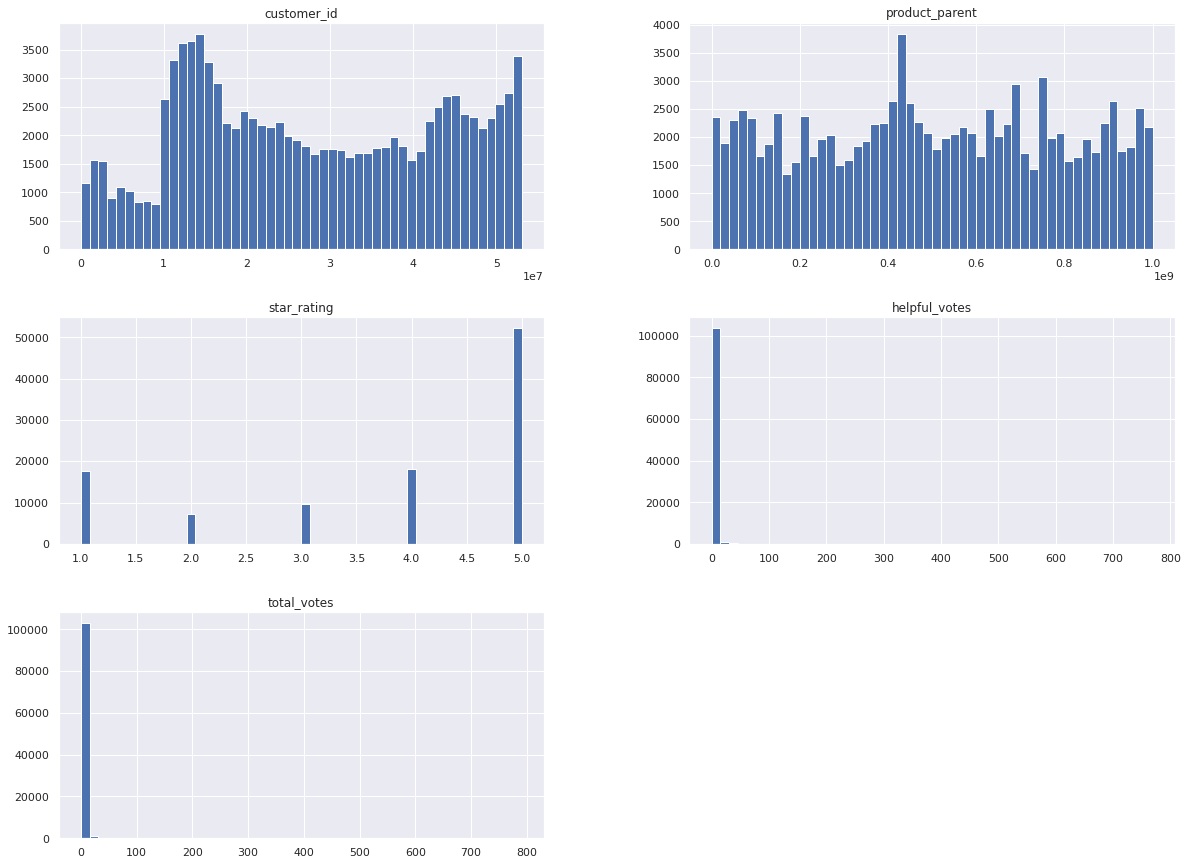

In [ ]:
# Builds histogram and set the number of bins and fig size (width, height)
data.hist(bins=50, figsize=(20,15))
plt.show()

#### Deriving additional information

In [ ]:
# Converting review_date to datetime object to extract month, day & year
%%time
data['review_date'] =  pd.to_datetime(data['review_date'], format='%Y-%m-%d')

CPU times: user 25.2 ms, sys: 2.02 ms, total: 27.3 ms
Wall time: 29.7 ms


In [ ]:
# Extracting month, day and year
%%time
data['day'] = data['review_date'].apply(lambda r:r.day)
data['month'] = data['review_date'].apply(lambda r:r.month)
data['year'] = data['review_date'].apply(lambda r:r.year)

CPU times: user 1.46 s, sys: 25.9 ms, total: 1.49 s
Wall time: 1.49 s


In [ ]:
data.head(2)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,day,month,year
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31,31,8,2015
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31,31,8,2015


#### Review Trend over time

CPU times: user 316 ms, sys: 91 ms, total: 407 ms
Wall time: 310 ms


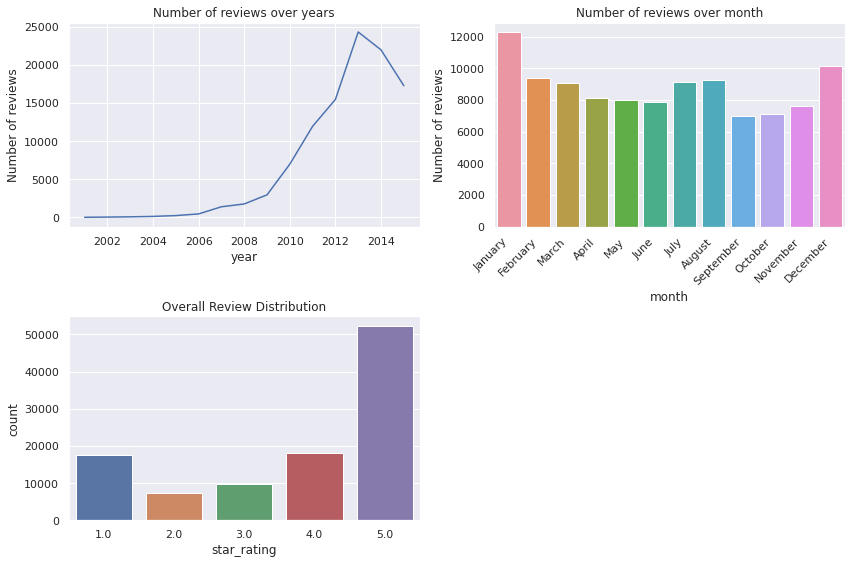

In [115]:
%%time
f, axes = plt.subplots(2,2, figsize=(12,8))
# Yearly Reviews
yearly = data.groupby(['year'])['review_id'].count().reset_index()
yearly = yearly.rename(columns={'review_id':'Number of reviews'})
year_trend = sns.lineplot(x='year',y='Number of reviews',data=yearly, ax = axes[0,0])
year_trend.set_title('Number of reviews over years')

# Monthly Reviews
monthly = data.groupby(['month'])['review_id'].count().reset_index()
monthly['month'] = monthly['month'].apply(lambda x : calendar.month_name[x])
monthly = monthly.rename(columns={'review_id':'Number of reviews'})
month_trend = sns.barplot(x='month',y='Number of reviews',data=monthly, ax = axes[0,1])
month_trend.set_title('Number of reviews over month')
month_trend.set_xticklabels(month_trend.get_xticklabels(), rotation = 45, horizontalalignment = 'right')

# Getting overall ratings for products
sns.countplot(x = 'star_rating', data = data, ax = axes[1,0] ).set_title('Overall Review Distribution')
f.delaxes(axes[1][1])
f.tight_layout()


***Rating Trend over the years***
- *There is an increasing trend for number of ratings given by the users to products on Amazon which indicates that a greater number of users started using the Amazon e-commerce site for online shopping and a greater number of users started giving feedback on the products purchased from 2006 to 2014. There is a significant increase in number of ratings given by users from 2012 to 2013.*
- *Notice the peak on 2013. Two major events support this. Amazon began to offer Sunday delivery option for purchases. See [news article](https://www.cnet.com/news/amazon-to-begin-offering-sunday-delivery-option-for-purchases/) here. That surely resulted in lots of new members and increased ratings & reviews.* 

***Distribution of overall ratings***
- *Many users have given a rating of 5 to products followed by 4 and 1 whereas very few users have given a low rating of 2 and 3.*


#### Distribution of reviews by word length

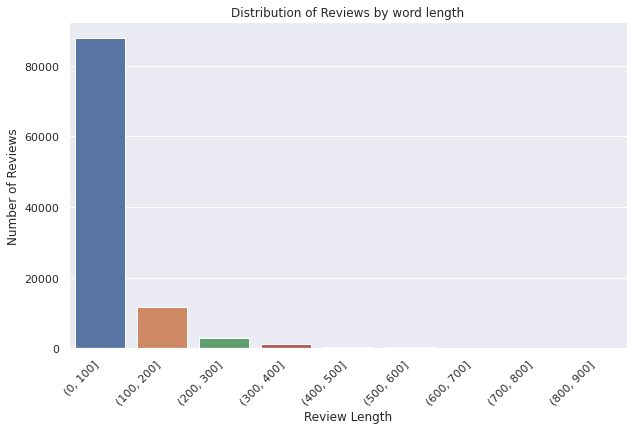

CPU times: user 619 ms, sys: 4.61 ms, total: 624 ms
Wall time: 631 ms


In [ ]:
%%time
plt.figure(figsize=(10,6))
electronics_reviews = data[['review_id','customer_id','review_body','review_headline','star_rating']]
electronics_reviews['review_length'] = electronics_reviews['review_body'].apply(lambda x: len(x.split()))
reviews_word_length = electronics_reviews.groupby(pd.cut(electronics_reviews.review_length, np.arange(0,1000,100))).count()
reviews_word_length = reviews_word_length.rename(columns={'review_length':'count'})
reviews_word_length = reviews_word_length.reset_index()
#print(reviews_word_length)
reviewLengthChart = sns.barplot(x='review_length',y='count',data=reviews_word_length)
reviewLengthChart.set_title('Distribution of Reviews by word length')
reviewLengthChart.set_xticklabels(reviewLengthChart.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.xlabel("Review Length")
plt.ylabel("Number of Reviews")
plt.show()

#### Reviews per product

<Figure size 720x432 with 0 Axes>

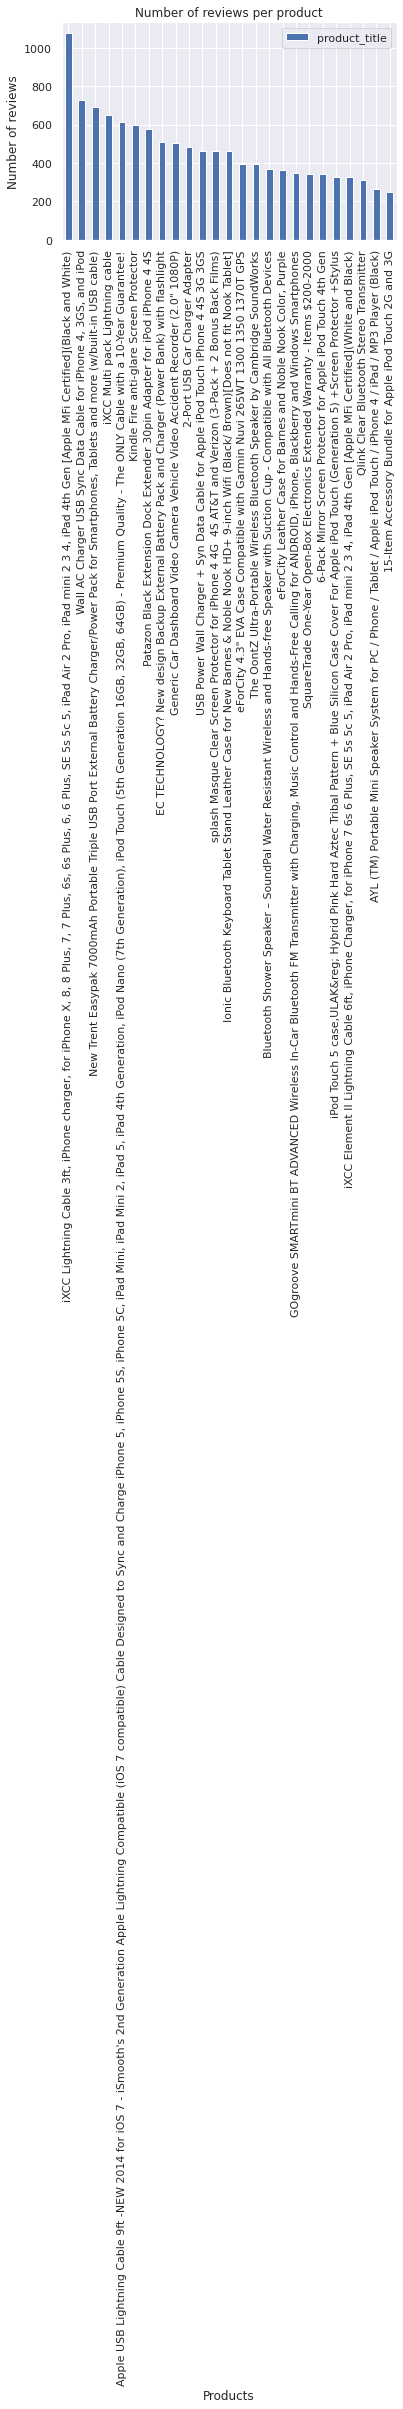

CPU times: user 577 ms, sys: 36.4 ms, total: 613 ms
Wall time: 610 ms


In [ ]:
%%time
plt.figure(figsize=(10,6))
counts = data["product_title"].value_counts().to_frame()
counts.loc[counts['product_title'] > 250].plot(kind='bar')
plt.xlabel("Products")
plt.ylabel("Number of reviews")
plt.title("Number of reviews per product")
plt.show()

#### Subsetting the dataframe to take the required columns

In [ ]:
# Subsetting the dataframe
reviews = data[['review_headline','review_body', 'star_rating']]

In [ ]:
# Concat review headline and review body columns into one single column
reviews['review'] = reviews['review_headline'].str.cat(reviews['review_body'],sep=" ")
reviews

,review_headline,review_body,star_rating,review
0,Very Happy!,"As advertised. Everything works perfectly, I'm...",5.0,Very Happy! As advertised. Everything works pe...
1,five star,it's great,5.0,five star it's great
2,great cables,These work great and fit my life proof case fo...,5.0,great cables These work great and fit my life ...
3,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,4.0,Work very well but couldn't get used to not he...
4,Cameras has battery issues,"Be careful with these products, I have bought ...",2.0,Cameras has battery issues Be careful with the...
...,...,...,...,...
104842,The Cat Barf is Gone!,"I've been looking for a while for the \\""purr\...",5.0,The Cat Barf is Gone! I've been looking for a ...
104843,Well worth [it],We live in an apartment with hardwood floors a...,5.0,Well worth [it] We live in an apartment with h...
104844,Its a Time saver!!!,I received this for a birthday present and Its...,5.0,Its a Time saver!!! I received this for a birt...
104845,Got Stains?,I got the Dirt Devil Spot Scrubber for a gift ...,5.0,Got Stains? I got the Dirt Devil Spot Scrubber...


## Polarity and Subjectivity

In [ ]:
## Calculating review polarity using TextBlob
%%time
polarity = lambda x: TextBlob(x).sentiment.polarity
reviews['review_polarity'] = reviews['review'].swifter.apply(polarity)


CPU times: user 1min 25s, sys: 680 ms, total: 1min 26s
Wall time: 1min 26s


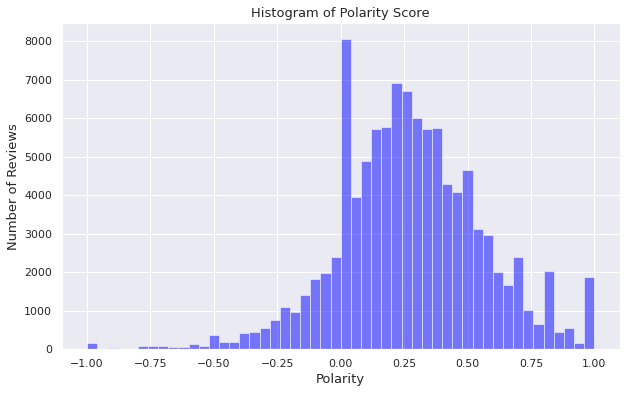

In [ ]:
# Plotting Histogram of Polarity Score
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(reviews.review_polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Number of Reviews', fontsize=13)
plt.title('Histogram of Polarity Score', fontsize=13)
plt.show()

*Although maximum reviews have positive emotions, there is peak for neutral reviews and be seen at 0.*

In [ ]:
# Calculating review subjectivity
%%time
sub = lambda x: TextBlob(x).sentiment.subjectivity
reviews['review_subjectivity'] = reviews['review'].swifter.apply(sub)


CPU times: user 1min 25s, sys: 723 ms, total: 1min 26s
Wall time: 1min 26s


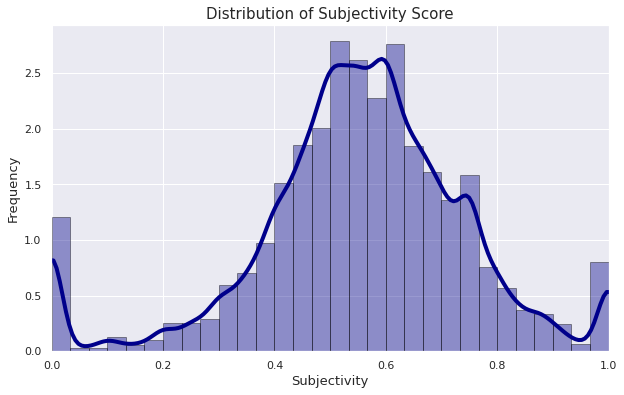

In [ ]:
# Plotting distribution of subjectivity
plt.figure(figsize=(10,6))
sns.distplot(reviews.review_subjectivity, hist=True, kde=True, bins=int(30), color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)
plt.show()

*There is quite a normal distribution for subjectivity. However, there are many reviews which are fully subjective and fully objective.*

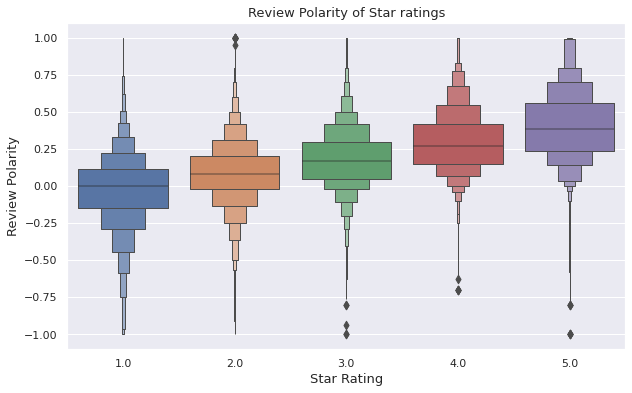

In [ ]:
# Plotting polarity of star ratings
plt.figure(figsize=(10,6))
sns.boxenplot(x='star_rating', y='review_polarity', data=reviews)
plt.xlabel("Star Rating", fontsize=13)
plt.ylabel("Review Polarity", fontsize=13)
plt.title("Review Polarity of Star ratings", fontsize=13)
plt.show()

*In the above plot, we can see that polarity increases with star rating. There are very few reviews with 5 rating and negative polarity and 1 rating with positve polarity.*

In [ ]:
#Some Positive reviews that has bad rating
reviews.loc[(reviews.review_polarity == -1) & (reviews.star_rating == 5)].review.head().tolist()

['The mount that comes with the g1wh is horrible. Worked as described. The mount that comes with the g1wh is horrible.',
 "THUMPER This sub pounds the hell out of my girls car, and for the price you can't go wrong!!! I have been a kenwood fan for some time and this does not disappoint!!!",
 "Crazy!!! Saw the video and bought this. You know this isn't Bose audio, but it works just like they say it does. Get one!",
 'terrible its does not record your voice for memos and you have to do it on the computer save your money']

*All the above reviews have the negative words which might have made the polarity negative. These words are: horrible, hell, wrong, disappoint*

In [ ]:
#Some Negative reviews that has good rating
reviews.loc[(reviews.review_polarity == 1) & (reviews.star_rating == 1)].review.head().tolist()

["One Star Wasn't very happy with it it did not have the power that I wanted",
 'One Star I am very happy with the product that I bought',
 "EARPOD doesn'work THE  EARPOD DIDN'T WORK ( had to buy one by Best Buy)<br />DELIVERED WITHOUT A MANUEL",
 'One Star The product had a shortage in the cord. I ordered another which worked perfectly.',
 'One Star one works perfectly and one is a defective']

*All the above reviews have the most positive words which might have made the polarity positive. These words are: Very happy, Best buy, perfectly*

## Review length

In [ ]:
# Calculating length of each review
length_of_review=[]

for i, word in enumerate(reviews.review.tolist()):
    word_length = len(word)
    length_of_review.append(word_length)
reviews['review_length'] =length_of_review
display(reviews)

,review_headline,review_body,star_rating,review,review_polarity,review_subjectivity,review_length
0,Very Happy!,"As advertised. Everything works perfectly, I'm...",5.0,Very Happy! As advertised. Everything works pe...,0.666667,0.666667,151
1,five star,it's great,5.0,five star it's great,0.800000,0.750000,20
2,great cables,These work great and fit my life proof case fo...,5.0,great cables These work great and fit my life ...,0.666667,0.633333,73
3,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,4.0,Work very well but couldn't get used to not he...,0.200000,0.300000,157
4,Cameras has battery issues,"Be careful with these products, I have bought ...",2.0,Cameras has battery issues Be careful with the...,0.139225,0.666667,168
...,...,...,...,...,...,...,...
104842,The Cat Barf is Gone!,"I've been looking for a while for the \\""purr\...",5.0,The Cat Barf is Gone! I've been looking for a ...,0.083258,0.509957,2788
104843,Well worth [it],We live in an apartment with hardwood floors a...,5.0,Well worth [it] We live in an apartment with h...,0.216212,0.521667,449
104844,Its a Time saver!!!,I received this for a birthday present and Its...,5.0,Its a Time saver!!! I received this for a birt...,0.252273,0.395455,574
104845,Got Stains?,I got the Dirt Devil Spot Scrubber for a gift ...,5.0,Got Stains? I got the Dirt Devil Spot Scrubber...,0.123290,0.523796,1835


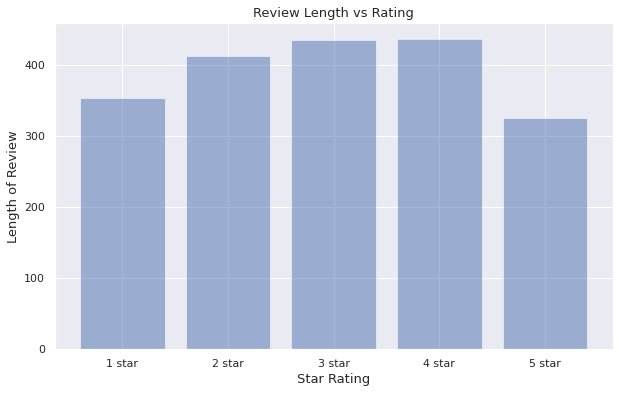

In [ ]:
# Plotting Star rating vs review length
L1= reviews[reviews['star_rating']==1]['review_length'].mean()
L2= reviews[reviews['star_rating']==2]['review_length'].mean()
L3= reviews[reviews['star_rating']==3]['review_length'].mean()
L4= reviews[reviews['star_rating']==4]['review_length'].mean()
L5= reviews[reviews['star_rating']==5]['review_length'].mean()
plt.figure(figsize=(10,6))
review_length_comparison=[L1,L2,L3,L4,L5]
objects = ('1 star','2 star','3 star', '4 star' ,'5 star')
y_pos = np.arange(len(objects))
plt.bar(y_pos, review_length_comparison, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Length of Review', fontsize=13)
plt.xlabel('Star Rating', fontsize=13)
plt.title('Review Length vs Rating', fontsize=13)
plt.show()

*People tend to give very long reviews when they are explaining details about the product. For example, if someone doesn't like a particular feature of some product they explain it in detail. On the other hand, best reviews mostly are given in few words.*

## Word Cloud

In [ ]:
# Creating word cloud
def review_word_cloud(reviews):
    words = " ".join(reviews)
                 
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
                 
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig("distributions.png")
    plt.show()

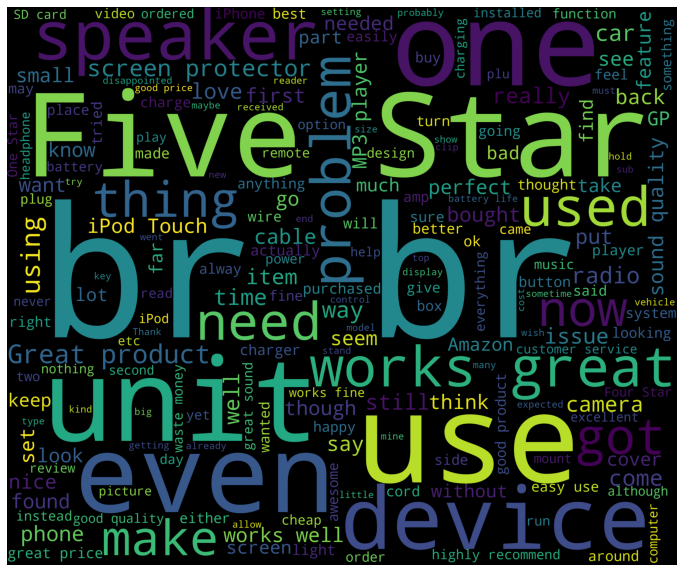

In [ ]:
review_word_cloud(reviews["review"])

*The above wordcloud is formed with the review text before text preprocessing.*

## Text2Emotion

*Emotion Detection from text is useful in many ways. It helps to understand the customers, analyze feedback and reviews.*

In [ ]:
t2e = reviews[['review', 'star_rating']]
t2e = t2e.sample(frac = 0.1)

In [ ]:
# Deriving emotion
start = time.time()
t2e["emotion_factor"] = t2e.review.map(te.get_emotion)
print((time.time()-start)/60, 'mins')

40.04022561709086 mins


In [ ]:
%%time
t2e = pd.concat([t2e, t2e['emotion_factor'].apply(pd.Series)], axis = 1)

CPU times: user 3.44 s, sys: 121 ms, total: 3.57 s
Wall time: 3.49 s


In [ ]:
t2e

,review,star_rating,emotion_factor,Happy,Angry,Surprise,Sad,Fear
70606,Kick butt Nice amp for low watts. Running kenw...,5.0,"{'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.25,...",0.50,0.00,0.25,0.25,0.00
31226,Really poor quality I got this to use at work ...,1.0,"{'Happy': 0.13, 'Angry': 0.0, 'Surprise': 0.33...",0.13,0.00,0.33,0.07,0.47
41292,Great Price - All Necessary Pieces - Buy it Th...,5.0,"{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.38...",0.25,0.00,0.38,0.25,0.12
95544,Worthwhile Alternative For anyone who finds an...,5.0,"{'Happy': 0.29, 'Angry': 0.0, 'Surprise': 0.0,...",0.29,0.00,0.00,0.29,0.43
22203,Very bad quality Broke in a month. After disas...,2.0,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.33,...",0.00,0.00,0.33,0.67,0.00
...,...,...,...,...,...,...,...,...
74084,"Yea This is good. Yea, really good. Just what ...",5.0,"{'Happy': 0.2, 'Angry': 0.0, 'Surprise': 0.1, ...",0.20,0.00,0.10,0.00,0.70
55372,Great product with a small downside I bought t...,4.0,"{'Happy': 0.29, 'Angry': 0.05, 'Surprise': 0.1...",0.29,0.05,0.19,0.05,0.43
27377,Four Stars Great back up cords!,4.0,"{'Happy': 1.0, 'Angry': 0.0, 'Surprise': 0.0, ...",1.00,0.00,0.00,0.00,0.00
101914,Cheap - you get what you pay for... Broke the ...,1.0,"{'Happy': 0.09, 'Angry': 0.0, 'Surprise': 0.36...",0.09,0.00,0.36,0.09,0.45


In [ ]:
# Deriving tone of the reviews
def get_tone(dct):
  sorted_d = sorted(dct.items(), key=lambda kv: kv[1], reverse=True)
  if sorted_d[1][1] != 0.0 and (sorted_d[0][1] != sorted_d[1][1]) :
    return  'More ' + sorted_d[0][0]+' Than '+sorted_d[1][0]
  elif sorted_d[0][1] == sorted_d[1][1]:
    return 'Both ' + sorted_d[0][0] + ' and ' + sorted_d[1][0]
  else:
    return sorted_d[0][0]

In [ ]:
# Deriving tone of each review
t2e["Tone"] = t2e.emotion_factor.apply(get_tone)
t2e.head()

,review,star_rating,emotion_factor,Happy,Angry,Surprise,Sad,Fear,Tone
70606,Kick butt Nice amp for low watts. Running kenw...,5.0,"{'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.25,...",0.50,0.0,0.25,0.25,0.00,More Happy Than Surprise
31226,Really poor quality I got this to use at work ...,1.0,"{'Happy': 0.13, 'Angry': 0.0, 'Surprise': 0.33...",0.13,0.0,0.33,0.07,0.47,More Fear Than Surprise
41292,Great Price - All Necessary Pieces - Buy it Th...,5.0,"{'Happy': 0.25, 'Angry': 0.0, 'Surprise': 0.38...",0.25,0.0,0.38,0.25,0.12,More Surprise Than Happy
95544,Worthwhile Alternative For anyone who finds an...,5.0,"{'Happy': 0.29, 'Angry': 0.0, 'Surprise': 0.0,...",0.29,0.0,0.00,0.29,0.43,More Fear Than Happy
22203,Very bad quality Broke in a month. After disas...,2.0,"{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.33,...",0.00,0.0,0.33,0.67,0.00,More Sad Than Surprise


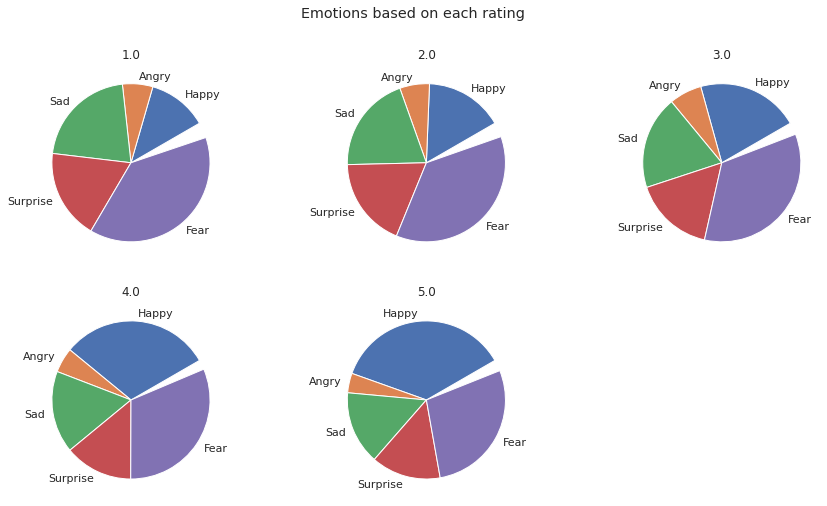

In [ ]:
# Plotting emotions based on each rating
ll =t2e.groupby("star_rating", as_index=True)[['Happy', 'Angry', 'Sad', 'Surprise', 'Fear']].mean()
ll.reset_index(inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.suptitle('Emotions based on each rating')

for i, (idx, row) in enumerate(ll.set_index('star_rating').iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, labels=row.index, startangle=30)
    ax.set_title(idx)
fig.delaxes(axes[1][2])
plt.show()

## Named Entity Recognition

*NER helps to get a glance, understand the subject or theme of the reviews*


In [ ]:
# Getting top 20 most helpful votes
helpful = data["helpful_votes"].tolist()
most_helpful = heapq.nlargest(20, helpful)

In [ ]:
# Joined the most helpful reviews
df_ner = data.loc[data.index.intersection(most_helpful)]
helpfultext = " ".join(df_ner['review_body'])
helpfultext

"Works great! Got it in red and black and already in love with it. Hands down one of the best Bluetooth speakers in this price range. If you're looking for cheap Bluetooth speakers SoundBot SB571 is the way to go. This is the worst radio I ever bought toch screen stop working very fast and the seller is the worst people to deal with don't buy from Waited a month maybe longer, when it finally arrived it was not a Acten but some other model.<br />rear view camera works fine but navigation icon does not respond. Does not flow easily will return. It was loud at first and then after a couple weeks it kinda just gave up and wouldn't turn up even with the volume on my phone all the way up. And then the side of it came off I don't recommend it. It was loud at first and then after a couple weeks it kinda just gave up and wouldn't turn up even with the volume on my phone all the way up. And then the side of it came off I don't recommend it. Seem to be well made, no issues as with cheaper product

In [ ]:
# Deriving entities
from collections import defaultdict
ner = spacy.load("en")
ner_helpful = ner(helpfultext)
ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)
for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

CARDINAL:
[one, two, two, about 10-15 feet, One, five]

ORG:
[SoundBot SB571, Sony, Sony, iPod, Considering, Toyota]

ORDINAL:
[first, first, first, first]

DATE:
[a couple weeks, a couple weeks, 2 days, two weeks]

GPE:
[kinda, kinda]

NORP:
[chinese]

MONEY:
[100 plus dollars]

LAW:
[the Camry Visor Repair]



In [ ]:
# Getting the most reviewed product
product = data[data["product_id"] == 'B00J46XO9U']

In [ ]:
# Joining reviews
product_text = " ".join(product['review_body'])
product_text

'Very good quality. So far so good. Good product and good seller Great product! They charge my wife\'s phone Works like a charm! I\'ve ordered a ton of these white and black, long and short.  I keep buying them because they are made so well.  I need more to buy for the office, my car, the house...etc... awesome stuff! It broke less than a month. Don\'t buy them. I\'ve bought a total of 3 of these cables I\'ve had the first for over a month and works great. Lasted longer than the ones I got from Apple. I needed one that worked with my lifeproof case and this does This cable works lightening-fast. As soon as I plug it into my iPhone, it recognizes the charger instantly and begins charging immediately. No need to wiggle the cable around the port to get it to fit properly or for the device to pick it up. I actually think it works better than the charger my iphone came with! I\'ve had it for over a year now and the wire is still in excellent shape. No tears to the cable, like you often have

In [ ]:
# Deriving entities
ner = spacy.load("en")
ner_helpful = ner(product_text)
ner_dict = defaultdict(list)
for entity in ner_helpful.ents:
    ner_dict[entity.label_].append(entity)
for NER, name in ner_dict.items():
    print(f"{NER}:\n{name}\n")

QUANTITY:
[a ton, 3ft, two 3 foot, 3 foot and, 6 foot, 3 foot, 6 foot, 2 charger, 6 ft cables, 3 foot, 10 foot, 6 foot, 3 feet, 3ft cables, 6ft cord's, 6ft, 3ft cables, 8 pin, 7.7 mm x, 5.7 mm, 10.4 mm, 6.0 mm, 6 ft, 3 Feet / 0.9 Meters, About an inch]

DATE:
[less than a month, over a month, over a year, the day, almost three months, 2 days, daily, over a year, a couple of months, months, over a few months, about 2 weeks, over a month, one year, several weeks, the day, the past couple months, 5 month, about a year, Less than a month, May, July, more than a few months, about 4 months, a week, daily, 6 months, about 6 months, one day, months, 1 day, 2 days, 18 months, 9 months, 2 months, about a week, a month, May 12th, just over a month, every day, a couple months, a couple weeks, the years, a year, 12w, since day one, a month, less than 4 months, a few months, a few weeks, a few months, 10 months, a few months, about 3 months, over 6 months, a few days, a month, a few weeks, just days

In [ ]:
# Using displacy to view entities
from spacy import displacy
displacy.render(ner_helpful, style="ent", jupyter=True)

## Text Preprocessing

In [ ]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r" v ", " very", phrase)
    phrase = re.sub(r'\bthats\b', 'that is', phrase)
    phrase = re.sub(r'\bive\b', 'i have', phrase)
    phrase = re.sub(r'\bim\b', 'i am', phrase)
    phrase = re.sub(r'\bya\b', 'yeah', phrase)
    phrase = re.sub(r'\bcant\b', 'can not', phrase)
    phrase = re.sub(r'\bdont\b', 'do not', phrase)
    phrase = re.sub(r'\bwont\b', 'will not', phrase)
    phrase = re.sub(r'\bid\b', 'i would', phrase)
    phrase = re.sub(r'wtf', 'what the fuck', phrase)
    phrase = re.sub(r'\bwth\b', 'what the hell', phrase)
    phrase = re.sub(r'\br\b', 'are', phrase)
    phrase = re.sub(r'\bu\b', 'you', phrase)
    phrase = re.sub(r'\bk\b', 'OK', phrase)
    phrase = re.sub(r'\bsux\b', 'sucks', phrase)
    phrase = re.sub(r'\bno+\b', 'no', phrase)
    phrase = re.sub(r'\bcoo+\b', 'cool', phrase)
    phrase = re.sub(r'rt\b', '', phrase)
    phrase = phrase.strip()
    #print("decontracted:",phrase)
    return phrase

In [ ]:
# exclude words from spacy stopwords list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False
 
# exclude words from spacy stopwords list
select_stop_words = ['#']
for w in select_stop_words:
    nlp.vocab[w].is_stop = True

In [ ]:
def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    #print("strip_html_tags:", stripped_text)
    return stripped_text

In [ ]:
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    #print("remove_accented_chars:", text)
    return text

In [ ]:
def remove_extra_characters(text):
    """remove extra characters from text, e.g. aaaaawwwweeeessssoooommmeee"""
    text = re.sub("(.)\\1{2,}", "\\1", text)
    #print("remove_extra_characters:", text)
    return text

In [ ]:
def keep_alphabet_numbers(text):
    """keep only words and numbers in the text"""
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

In [ ]:
def remove_urls(text):
    """remove url from the text"""
    # remove hyperlinks
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)
    return text

In [ ]:
def text_preprocessing(text):
    """preprocess text with default option set to true for all steps"""
    text = strip_html_tags(text)
    text = remove_urls(text)
    text = remove_accented_chars(text)
    text = decontracted(text)
    text = remove_extra_characters(text)
    text = keep_alphabet_numbers(text)
    text = text.lower()
    tokens = nlp(text)
    review_text = [word for word in tokens if not word.is_stop]
    review_text = [word.lemma_ for word in review_text]
    return " ".join(review_text)


In [ ]:
# Applying text-preprocessing to all the reviews
start = time.time()
reviews['preprocessed_review'] = reviews['review'].swifter.apply(lambda x: text_preprocessing(x))

print((time.time()-start)/60, 'mins')


25.671643646558127 mins


In [ ]:
# Resetting the index
reviews = reviews.reset_index(drop=True)

In [ ]:
reviews.head()

,review_headline,review_body,star_rating,review,review_polarity,review_subjectivity,review_length,preprocessed_review
0,Very Happy!,"As advertised. Everything works perfectly, I'm...",5.0,Very Happy! As advertised. Everything works pe...,0.666667,0.666667,151,happy advertise work perfectly happy camera ma...
1,five star,it's great,5.0,five star it's great,0.800000,0.750000,20,star great
2,great cables,These work great and fit my life proof case fo...,5.0,great cables These work great and fit my life ...,0.666667,0.633333,73,great cable work great fit life proof case iph...
3,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,4.0,Work very well but couldn't get used to not he...,0.200000,0.300000,157,work not not hear work not not hear ear verywe...
4,Cameras has battery issues,"Be careful with these products, I have bought ...",2.0,Cameras has battery issues Be careful with the...,0.139225,0.666667,168,cameras battery issue careful product buy came...


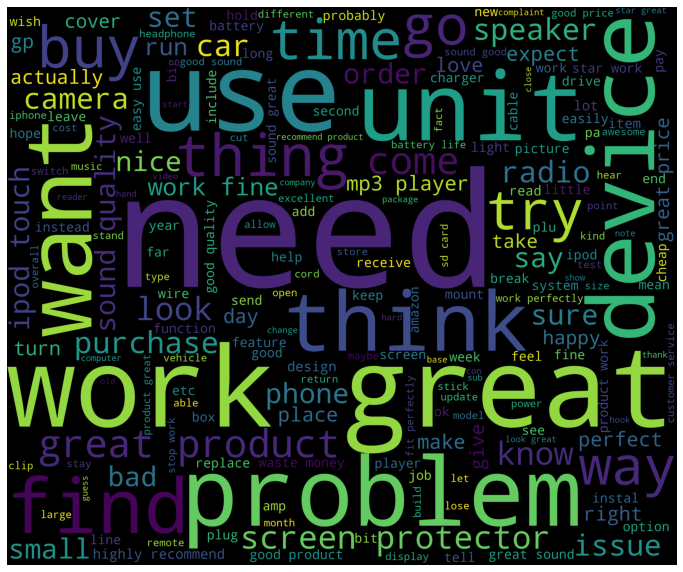

In [ ]:
review_word_cloud(reviews["preprocessed_review"])

*The above wordcloud is formed using the the preprocessed text*

## Sentiment Analysis

*Sentiment Analysis is the automated process of understanding the sentiment or opinion of a given text. It provides insights by automatically analyzing product reviews and separating them into tags: Positive, Neutral, Negative. In this part, We have used a prebuilt library VaderSentiment which is used in predicting the sentiment of a review based on the lexicon arrangement of the words in a review.*

In [ ]:
sid = nltk.sentiment.vader.SentimentIntensityAnalyzer()

In [ ]:
# Storing the sentiment scores of postive, neutral & negative sentiments in lists
pos_word_score=[]
neu_word_score=[]
neg_word_score=[]
for i, word in enumerate(reviews.preprocessed_review.tolist()):
    temp= sid.polarity_scores(word)
    pos_word_score.append(temp['pos'])
    neu_word_score.append(temp['neu'])
    neg_word_score.append(temp['neg'])

In [ ]:
reviews['positive_sentiment'] =pos_word_score
reviews['neutral_sentiment'] =neu_word_score
reviews['negative_sentiment'] =neg_word_score
reviews.head()

,review_headline,review_body,star_rating,review,review_polarity,review_subjectivity,review_length,preprocessed_review,positive_sentiment,neutral_sentiment,negative_sentiment
0,Very Happy!,"As advertised. Everything works perfectly, I'm...",5.0,Very Happy! As advertised. Everything works pe...,0.666667,0.666667,151,happy advertise work perfectly happy camera ma...,0.614,0.386,0.0
1,five star,it's great,5.0,five star it's great,0.800000,0.750000,20,star great,0.804,0.196,0.0
2,great cables,These work great and fit my life proof case fo...,5.0,great cables These work great and fit my life ...,0.666667,0.633333,73,great cable work great fit life proof case iph...,0.641,0.359,0.0
3,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,4.0,Work very well but couldn't get used to not he...,0.200000,0.300000,157,work not not hear work not not hear ear verywe...,0.000,1.000,0.0
4,Cameras has battery issues,"Be careful with these products, I have bought ...",2.0,Cameras has battery issues Be careful with the...,0.139225,0.666667,168,cameras battery issue careful product buy came...,0.286,0.714,0.0


In [ ]:
# Deriving average positive, negative and neutral sentiment of the dataset
avg_pos_sentiment = reviews['positive_sentiment'].mean()
avg_neu_sentiment = reviews['neutral_sentiment'].mean()
avg_neg_sentiment = reviews['negative_sentiment'].mean()
print("Average Positive Sentiment of dataset:",avg_pos_sentiment)
print("Average Neutral Sentiment of dataset:",avg_neu_sentiment)
print("Average Negative Sentiment of dataset:",avg_neg_sentiment)

Average Positive Sentiment of dataset: 0.3263287647715188
Average Neutral Sentiment of dataset: 0.5806806394079025
Average Negative Sentiment of dataset: 0.09294456684502155


## Topic Modeling using LDA

*Topic Modeling is a process to automatically identify topics present in a text object and to derive hidden patterns exhibited by a text corpus.
Topic Modeling enables consumers to quickly extract the key topics covered by the reviews without having to go through all of them. It also helps the sellers/retailers get consumer feedback in the form of topics (extracted from the consumer reviews).*

In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
 
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
 
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(10,6))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.title("Most Frequent words")
  plt.tight_layout()
  plt.show()

In [ ]:
review_list = [w for w in reviews['preprocessed_review']]

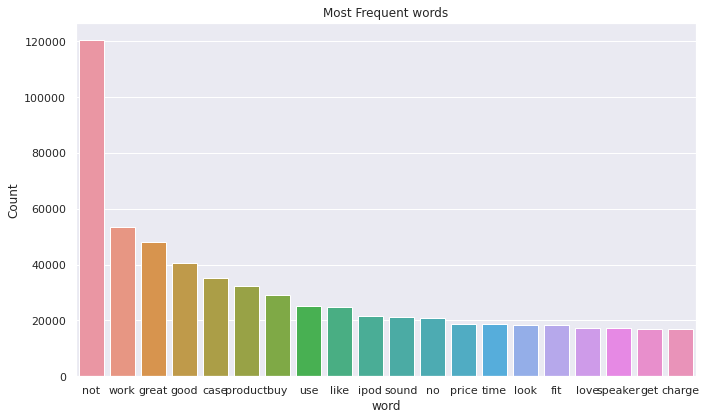

In [ ]:
freq_words(review_list, 20)

In [104]:
tokenized_reviews = pd.Series(review_list).apply(lambda x: x.split())
print(tokenized_reviews[1])

['star', 'great']


In [ ]:
dictionary = corpora.Dictionary(tokenized_reviews)

In [ ]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [ ]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel
 
# Building LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=1000, passes=25)

In [ ]:
# print topics
lda_model.print_topics()

[(0,
  '0.048*"scratch" + 0.040*"ok" + 0.031*"dock" + 0.028*"clean" + 0.026*"sub" + 0.022*"christmas" + 0.020*"star" + 0.015*"apa" + 0.013*"flip" + 0.013*"pod"'),
 (1,
  '0.041*"charge" + 0.031*"battery" + 0.031*"charger" + 0.029*"protector" + 0.024*"not" + 0.024*"cable" + 0.021*"iphone" + 0.020*"phone" + 0.017*"use" + 0.016*"work"'),
 (2,
  '0.093*"not" + 0.024*"work" + 0.022*"buy" + 0.019*"product" + 0.013*"get" + 0.011*"time" + 0.011*"no" + 0.010*"item" + 0.010*"try" + 0.009*"money"'),
 (3,
  '0.042*"player" + 0.033*"not" + 0.022*"ipod" + 0.021*"mp3" + 0.020*"use" + 0.019*"play" + 0.017*"music" + 0.012*"work" + 0.011*"song" + 0.011*"device"'),
 (4,
  '0.024*"screen" + 0.020*"video" + 0.015*"mount" + 0.014*"light" + 0.012*"software" + 0.009*"unit" + 0.009*"camera" + 0.009*"display" + 0.008*"easy" + 0.007*"file"'),
 (5,
  '0.020*"gps" + 0.019*"unit" + 0.017*"book" + 0.015*"transmitter" + 0.015*"protection" + 0.014*"zen" + 0.014*"reader" + 0.013*"stand" + 0.013*"read" + 0.012*"garmin"'

*The Topic 1 has terms like 'charge', 'charger', 'battery' indicating that the topic is very much related to phone charging. Similarly, Topic 8 seems to be about the overall value of the product as it has terms like 'excellent', 'great', and 'recommend'*

*To visualize our topics in a 2-dimensional space we used the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.*

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.145571  0.009616       1        1  23.929915
6      0.186456  0.101079       2        1  13.611570
3      0.069620 -0.130395       3        1  11.224414
1      0.021856 -0.131341       4        1  10.272508
9      0.138189  0.059664       5        1   9.438555
4     -0.014328 -0.142576       6        1   9.209987
8      0.164272  0.242076       7        1   7.504656
7     -0.172788 -0.143916       8        1   6.189265
5     -0.165794 -0.157104       9        1   6.144836
0     -0.373054  0.292896      10        1   2.474295, topic_info=         Term           Freq          Total Category  logprob  loglift
11      great   45885.000000   45885.000000  Default  30.0000  30.0000
15       case   36462.000000   36462.000000  Default  29.0000  29.0000
34    product   37061.000000   37061.000000  Default  28.0000  28.0000
22        not  114556.000000  114556.000000  Default  27.0000  27.0000
10       work   41898.000000   41898.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
12       star    1601.734624    5227.781146  Topic10  -3.9354   2.5163
1797      son     591.897655    1187.480097  Topic10  -4.9309   3.0030
1352     mess     476.727714     779.140743  Topic10  -5.1473   3.2080
513    chance     445.824573     753.732912  Topic10  -5.2144   3.1741
342         c     380.593101     624.206214  Topic10  -5.3726   3.2045

[594 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
272       8  0.999430      00
132       1  0.313541       1
132       4  0.170931       1
132       5  0.081706       1
132       6  0.174691       1
...     ...       ...     ...
252       7  0.023398    year
252       8  0.191087    year
1459      9  0.999769     zen
4032      2  0.999680  zipper
465       2  0.999779    zune

[942 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 2, 10, 5, 9, 8, 6, 1])

## Classification Models

In [ ]:
# Defining features and labels
review_data = reviews.copy()
y = review_data['star_rating'].values
y = y.astype('int')
X = review_data['preprocessed_review']

In [ ]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(
        min_df=2,               
        max_df=0.95,            
        ngram_range = (1,4),   
        stop_words = 'english', 
        )
# Extract features from reviews.
review_features = vectorizer.fit_transform(X)

In [ ]:
# Split the dataset to be 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(review_features,   
                                            y,           
                                            stratify=y,  
                                            random_state = 42,
                                            test_size = 0.2    
                                            )
print(X_train.shape)

(83877, 520053)


In [ ]:
# Logistic Regression model
lr = LogisticRegression(random_state=22).fit(X_train, y_train)
print( classification_report(y_test, lr.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.6684    0.8002    0.7284      3514
           2     0.3813    0.0671    0.1142      1460
           3     0.4792    0.2073    0.2894      1944
           4     0.4304    0.2499    0.3162      3613
           5     0.7125    0.9260    0.8054     10439

    accuracy                         0.6620     20970
   macro avg     0.5344    0.4501    0.4507     20970
weighted avg     0.6118    0.6620    0.6122     20970



In [ ]:
# MultinomialNB model
nb = MultinomialNB()
nb.fit(X_train, y_train)
print( classification_report(y_test, nb.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.8732    0.2783    0.4221      3514
           2     0.0000    0.0000    0.0000      1460
           3     0.7222    0.0067    0.0133      1944
           4     0.6471    0.0030    0.0061      3613
           5     0.5263    0.9989    0.6894     10439

    accuracy                         0.5451     20970
   macro avg     0.5538    0.2574    0.2262     20970
weighted avg     0.5867    0.5451    0.4162     20970



In [ ]:
# SGDClassifier
sgd = SGDClassifier(random_state=22)
sgd.fit(X_train, y_train)
print( classification_report(y_test, sgd.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.6372    0.7866    0.7040      3514
           2     0.2708    0.0089    0.0172      1460
           3     0.5647    0.1055    0.1777      1944
           4     0.4252    0.0551    0.0975      3613
           5     0.6469    0.9762    0.7782     10439

    accuracy                         0.6377     20970
   macro avg     0.5090    0.3864    0.3549     20970
weighted avg     0.5733    0.6377    0.5398     20970



In [ ]:
# RandomForestClassifier
forest = RandomForestClassifier(n_estimators=25, criterion="entropy", random_state=42)
forest.fit(X_train, y_train)
print( classification_report(y_test, forest.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.6490    0.6713    0.6600      3514
           2     0.2812    0.0123    0.0236      1460
           3     0.4367    0.0514    0.0920      1944
           4     0.3326    0.0435    0.0769      3613
           5     0.6101    0.9685    0.7486     10439

    accuracy                         0.6077     20970
   macro avg     0.4619    0.3494    0.3202     20970
weighted avg     0.5299    0.6077    0.5067     20970



In [ ]:
# LinearSVC
svc = LinearSVC(C = 20, class_weight= 'balanced')
svc.fit(X_train, y_train)
print( classification_report(y_test, svc.predict(X_test), digits=4))

              precision    recall  f1-score   support

           1     0.6602    0.7271    0.6920      3514
           2     0.2690    0.1555    0.1970      1460
           3     0.3235    0.2320    0.2702      1944
           4     0.3577    0.3006    0.3267      3613
           5     0.7401    0.8384    0.7862     10439

    accuracy                         0.6233     20970
   macro avg     0.4701    0.4507    0.4544     20970
weighted avg     0.5894    0.6233    0.6024     20970



## Model Tuning

*We performed parameter tuning using sklearn’s GridSearchCV algorithm. GridSearchCV does an exhaustive search over specified parameter values.*

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = { 'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2] }
nb_clf = GridSearchCV(MultinomialNB(), parameters)
nb_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75,
                                   2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
# Print out the parameters GridSearchCV decided on.
nb_clf.best_params_

{'alpha': 0.1}

In [112]:
parameters = [{ 'loss': ['hinge', 'log', 'perceptron'], 
                'alpha': 10.0**-np.arange(1,7),
                'penalty': ['l1', 'l2', 'elasticnet']}]
sgd_clf = GridSearchCV(SGDClassifier(random_state=22), parameters)
sgd_clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=22,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                          'loss': ['hinge', 'log', 'perceptron'],
                          'penalty': ['l1', 'l2', 

In [111]:
# Print out the parameters GridSearchCV decided on.
sgd_clf.best_params_

{'alpha': 1e-05, 'loss': 'log', 'penalty': 'l1'}

In [ ]:
classifiers = [lr, nb, sgd, forest, svc]
names_of_classifiers = ["Logistic Regression","Multinomial Naive Bayes","SGD", "Random Forest", "Linear SVC"]

In [ ]:
# Create, fit and predict the star ratings using the Machine Learning classifiers
acc_score=[]

for index,clf in enumerate(classifiers):
    
    y_pred = clf.predict(X_test)
    acc= accuracy_score(y_test, y_pred)
    acc_score.append(acc*100)
    
    if index == len(classifiers) - 1:
      cm=confusion_matrix(y_test,y_pred)
 

In [ ]:
import os

In [ ]:
# Plotting the accuracy comparison 
x = names_of_classifiers
acc = acc_score
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(acc))  # the x locations for the groups
ax.barh(ind, acc, width, color=(0.2, 0.4, 0.6, 0.6))
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(acc):
    temp = float(v)
    ax.text(0.5, i+0.1,str(round(v,2)))
plt.title('Accuracy Comparsion')
plt.xlabel('Accuracy')
plt.ylabel('Classifiers')      
#plt.show()
plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight')

In [113]:
# print classification reports
print("\nclassification reports: ")
print( "LogisticRegression: " )
print( classification_report(y_test, lr.predict(X_test), digits=4))
print( "MultinomialNB: " ) 
print( classification_report(y_test, nb_clf.predict(X_test), digits=4))
print( "SGDClassifier: " ) 
print( classification_report(y_test, sgd_clf.predict(X_test), digits=4))
print( "Random Forest: " ) 
print( classification_report(y_test, forest.predict(X_test), digits=4))
print( "SVC: " ) 
print( classification_report(y_test, svc.predict(X_test), digits=4))


classification reports: 
LogisticRegression: 
              precision    recall  f1-score   support

           1     0.6684    0.8002    0.7284      3514
           2     0.3813    0.0671    0.1142      1460
           3     0.4792    0.2073    0.2894      1944
           4     0.4304    0.2499    0.3162      3613
           5     0.7125    0.9260    0.8054     10439

    accuracy                         0.6620     20970
   macro avg     0.5344    0.4501    0.4507     20970
weighted avg     0.6118    0.6620    0.6122     20970

MultinomialNB: 
              precision    recall  f1-score   support

           1     0.6479    0.7610    0.6999      3514
           2     0.3100    0.0212    0.0397      1460
           3     0.4005    0.0880    0.1442      1944
           4     0.3522    0.2380    0.2841      3613
           5     0.6855    0.9111    0.7824     10439

    accuracy                         0.6317     20970
   macro avg     0.4792    0.4039    0.3901     20970
weighted avg  

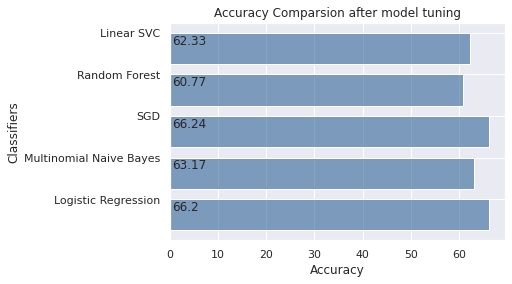

In [114]:
# Create, fit and predict the star ratings using the Machine Learning classifiers
acc_score=[]
refined_classifiers = [lr, nb_clf, sgd_clf, forest, svc]
for index,clf in enumerate(refined_classifiers):
    
    y_pred = clf.predict(X_test)
    acc= accuracy_score(y_test, y_pred)
    acc_score.append(acc*100)
    
    if index == len(refined_classifiers) - 1:
      cm=confusion_matrix(y_test,y_pred)

x = ["Logistic Regression","Multinomial Naive Bayes","SGD", "Random Forest", "Linear SVC"]
acc = acc_score
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(acc))  # the x locations for the groups
ax.barh(ind, acc, width, color=(0.2, 0.4, 0.6, 0.6))
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
for i, v in enumerate(acc):
    temp = float(v)
    ax.text(0.5, i+0.1,str(round(v,2)))
plt.title('Accuracy Comparsion after model tuning')
plt.xlabel('Accuracy')
plt.ylabel('Classifiers')      
#plt.show()
plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight')

In [ ]:
# Plotting confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.figure( figsize=(9,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(y)))
    plt.xticks(tick_marks, set(y), rotation=45)
    plt.yticks(tick_marks, set(y))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [110]:
def create_and_print_confusion_matrix(y_test, predicted, title):
    cm = confusion_matrix(y_test, predicted)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cm, title) 
    plt.show()

<Figure size 432x288 with 0 Axes>

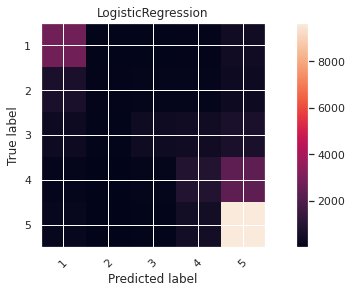

In [109]:
create_and_print_confusion_matrix(y_test, lr.predict(X_test), "LogisticRegression")

<Figure size 432x288 with 0 Axes>

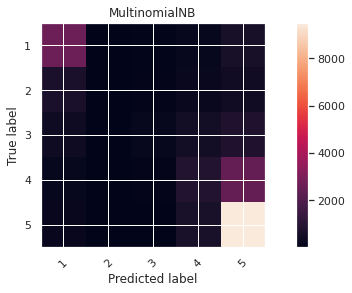

In [108]:
# Create MultinomialNB confusion matrix.
create_and_print_confusion_matrix(y_test, nb_clf.predict(X_test),"MultinomialNB")

<Figure size 432x288 with 0 Axes>

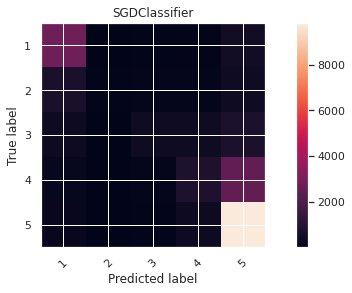

In [107]:
# Create SGDClassifier confusion matrix.
create_and_print_confusion_matrix(y_test, sgd_clf.predict(X_test), "SGDClassifier")

<Figure size 432x288 with 0 Axes>

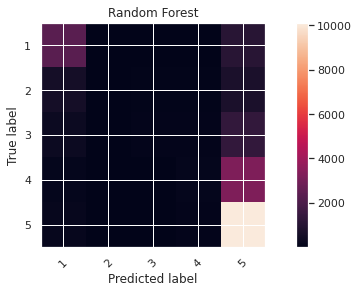

In [106]:
create_and_print_confusion_matrix(y_test, forest.predict(X_test), "Random Forest")

<Figure size 432x288 with 0 Axes>

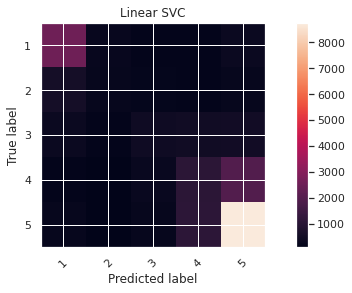

In [105]:
create_and_print_confusion_matrix(y_test, svc.predict(X_test), "Linear SVC")

REFERENCES:

Band, A. (2020, September 27). Text2emotion: Python package to detect emotions from textual data. Retrieved November 29, 2020, from https://towardsdatascience.com/text2emotion-python-package-to-detect-emotions-from-textual-data-b2e7b7ce1153

Confusion Matrix in Machine Learning. (2020, August 21). Retrieved November 29, 2020, from https://www.geeksforgeeks.org/confusion-matrix-machine-learning/

Joshi, P. (2020, June 25). SpaCy Tutorial: SpaCy For NLP: SpaCy NLP Tutorial. Retrieved November 29, 2020, from https://www.analyticsvidhya.com/blog/2020/03/spacy-tutorial-learn-natural-language-processing/

Kadam, S. (2020, April 18). Generating Word Cloud in Python. Retrieved November 29, 2020, from https://www.geeksforgeeks.org/generating-word-cloud-python/

Logistic Regression 3-class Classifier¶. (n.d.). Retrieved November 29, 2020, from https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html?highlight=logistic+regression

Notebook on nbviewer. (n.d.). Retrieved November 29, 2020, from https://nbviewer.jupyter.org/github/bmabey/hacker_news_topic_modelling/blob/master/HN Topic Model Talk.ipynb

Rai, A. (2019, January 23). Python: Sentiment Analysis using VADER. Retrieved November 29, 2020, from https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

Simplified Text Processing¶. (n.d.). Retrieved November 29, 2020, from https://textblob.readthedocs.io/en/dev/

Sklearn.model_selection.GridSearchCV¶. (n.d.). Retrieved November 29, 2020, from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html